***

# Text Based Recommendations
### - dataset : [MIND: Microsoft News Recommendation Dataset](https://www.kaggle.com/datasets/arashnic/mind-news-dataset)
### - method : TF-IDF embedding
### - feature : \[text\] news abstract

***

## 0) Import library

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from nltk import Tree
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
plt.style.use('seaborn-white')
pd.options.display.float_format = '{:.4f}'.format

***

## 1) Data processing

### load data

In [3]:
news = pd.read_csv("data/MIND/news.tsv", delimiter='\t', header=None, 
                        names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract entities'])
news

,news_id,category,subcategory,title,abstract,url,title_entities,abstract entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
...,...,...,...,...,...,...,...,...
51277,N16909,weather,weathertopstories,"Adapting, Learning And Soul Searching: Reflect...",Woolsey Fire Anniversary: A community is forev...,https://assets.msn.com/labs/mind/BBWzQJK.html,"[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid...","[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid..."
51278,N47585,lifestyle,lifestylefamily,Family says 13-year-old Broadway star died fro...,NaN,https://assets.msn.com/labs/mind/BBWzQYV.html,"[{""Label"": ""Broadway theatre"", ""Type"": ""F"", ""W...",[]
51279,N7482,sports,more_sports,St. Dominic soccer player tries to kick cancer...,"Sometimes, what happens on the sidelines can b...",https://assets.msn.com/labs/mind/BBWzQnK.html,[],[]
51280,N34418,sports,soccer_epl,How the Sounders won MLS Cup,"Mark, Jeremiah and Casey were so excited they ...",https://assets.msn.com/labs/mind/BBWzQuK.html,"[{""Label"": ""MLS Cup"", ""Type"": ""U"", ""WikidataId...",[]


In [4]:
data = news[['news_id', 'abstract']]
data

,news_id,abstract
0,N55528,"Shop the notebooks, jackets, and more that the..."
1,N19639,These seemingly harmless habits are holding yo...
2,N61837,Lt. Ivan Molchanets peeked over a parapet of s...
3,N53526,"I felt like I was a fraud, and being an NBA wi..."
4,N38324,"They seem harmless, but there's a very good re..."
...,...,...
51277,N16909,Woolsey Fire Anniversary: A community is forev...
51278,N47585,NaN
51279,N7482,"Sometimes, what happens on the sidelines can b..."
51280,N34418,"Mark, Jeremiah and Casey were so excited they ..."


### remove missing values

In [5]:
data = data.dropna()
data

,news_id,abstract
0,N55528,"Shop the notebooks, jackets, and more that the..."
1,N19639,These seemingly harmless habits are holding yo...
2,N61837,Lt. Ivan Molchanets peeked over a parapet of s...
3,N53526,"I felt like I was a fraud, and being an NBA wi..."
4,N38324,"They seem harmless, but there's a very good re..."
...,...,...
51275,N17258,Over 400 percent more phones shipped year-on-year
51276,N23858,When the U.S. women's national soccer team arr...
51277,N16909,Woolsey Fire Anniversary: A community is forev...
51279,N7482,"Sometimes, what happens on the sidelines can b..."


### tokenize
remove stopwords, remain nouns and verb, lower sentence

In [6]:
stop_words = stopwords.words('english')
stop_words += ['']
def tokenize(sentence):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    tokenized = tokenizer.tokenize(sentence)
    removed_sw = [w for w in tokenized if w not in stop_words]
    tag = nltk.pos_tag(removed_sw)
    nouns = [t[0] for t in tag if t[1][0] in ['N', 'V'] and t[1] not in ['NNP', 'NNPS']]
    lower = [w.lower() for w in nouns]
    
    return " ".join(lower)

In [7]:
abstract = data['abstract'].apply(tokenize).tolist()
abstract[:5]

['notebooks jackets royals live',
 'habits holding keeping shedding unwanted',
 'peeked parapet sand bags line war helmet propped snipers perforated holes',
 'felt fraud wife help fact destroyed',
 'seem reason post according appeared']

***

## 2) Modeling

### calculate TF-IDF vector

In [8]:
tfidf = TfidfVectorizer()
tfidf.fit(abstract)
embedding = tfidf.transform(abstract).toarray()

In [9]:
sorted_vocab = sorted(tfidf.vocabulary_.items(), key = lambda item: item[1])
sorted_vocab = [vocab[0] for vocab in sorted_vocab]
embedding_df = pd.DataFrame(embedding, index=data['news_id'], columns=sorted_vocab)
embedding_df

,aahs,aannounced,ab,ababy,aback,abalone,abandon,abandoned,abandoning,abandonment,...,zoning,zoo,zookeeper,zookeepers,zoomed,zooming,zoos,zorbing,zyp,zzzs
news_id,,,,,,,,,,,,,,,,,,,,,
N55528,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
N19639,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
N61837,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
N53526,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
N38324,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N17258,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
N23858,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
N16909,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


### visualize similar news using T-SNE

In [12]:
tsne = TSNE(n_components=2, n_iter=1000)
tsne_score = tsne.fit_transform(embedding)

In [13]:
hue = news.loc[data.index]['category']

C:\Users\HS\anaconda3\envs\reco_sys\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\HS\anaconda3\envs\reco_sys\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


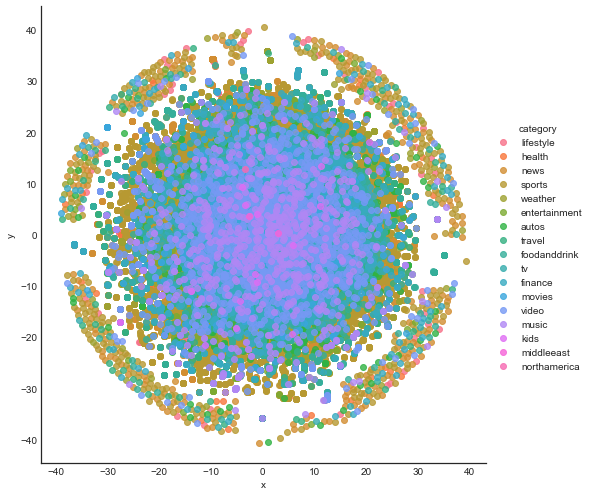

In [14]:
tsne_df = pd.DataFrame(np.concatenate([tsne_score, hue.values[:,np.newaxis]], axis=1),
                      columns=['x', 'y', 'category'])
sns.lmplot('x', 'y', data=tsne_df, fit_reg=False, size=7, hue='category')
plt.show()

***

## 3) Recommendation

### define function for recommendation

In [10]:
def get_similar_news(news_id, top_k):
    similarities = cosine_similarity(embedding_df.loc[news_id].values.reshape(1,-1),
                                     embedding_df.loc[~embedding_df.index.isin([news_id])])
    idx = embedding_df.index.tolist()
    idx.remove(news_id)
    
    argsort = np.argsort(similarities.reshape(-1))[-1::-1][:top_k]
    
    ret = np.array(idx)[argsort]
    return ret.tolist()

### example

In [11]:
reco = get_similar_news(news_id="N2073", top_k=30)
print(f"Similar news :")
print("\n".join(reco))

Similar news :
N12820
N29343
N45279
N61576
N45596
N23588
N37221
N53190
N49465
N60899
N58876
N21672
N60562
N19358
N8345
N47073
N51364
N48153
N4139
N38746
N35316
N36355
N23810
N29891
N2091
N41346
N12200
N15278
N27890
N17271
